In [55]:
import numpy as np
from PIL import Image
import sys
import os
import cv2
from sklearn.cluster import KMeans

# Get the absolute path of the root directory where the `awesome` folder is located
root_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Add the root path to sys.path
sys.path.append(root_path)

# Verify the path is correct
print("Root Path Added to sys.path:", root_path)





from awesome.util.path_tools import get_project_root_path
from awesome.run.functions import plot_as_image, get_mpl_figure, plot_mask

from tqdm.auto import tqdm
from awesome.model.zoo import Zoo
from awesome.model.convex_net import ConvexNextNet
from awesome.run.runner import seed_all
from awesome.util.torch import tensorify
import torch
from matplotlib.colors import get_named_colors_mapping
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff()
zoo = Zoo()



Root Path Added to sys.path: /Users/kenjileong/Documents/GitHub/awesome


# Load images

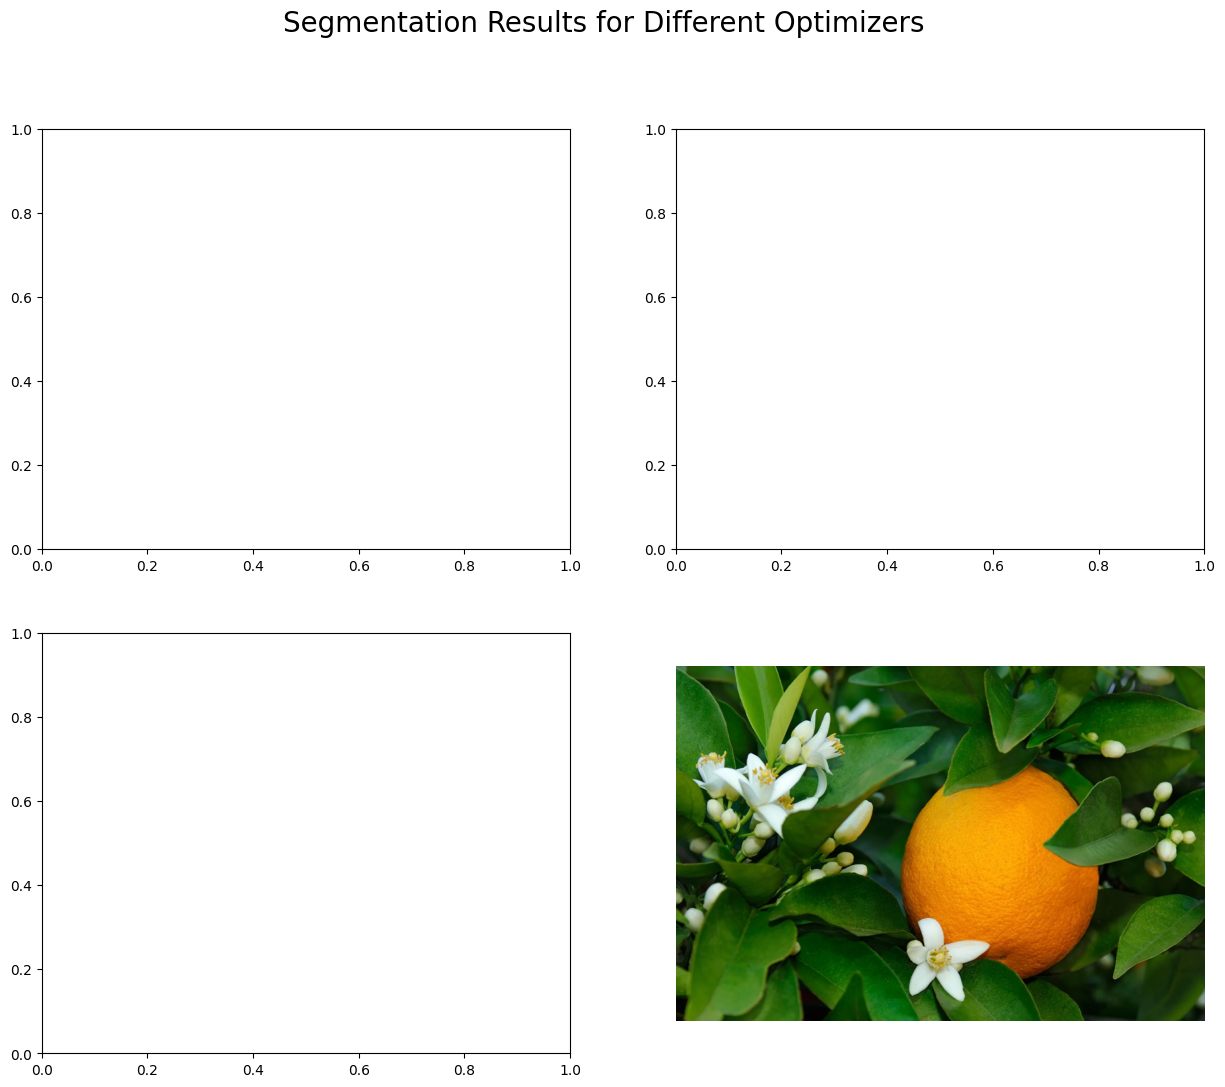

In [56]:
# img_dir="data/cocktail-tomatoes.jpg"
img_dir="data/orange.jpg"


def load_image(path: str, down_scale: int = 1) -> np.ndarray:
    img_pil=Image.open(path)
    width, height = img_pil.size 
    newsize = (int(width/down_scale), int(height/down_scale))
    img_pil = img_pil.resize(newsize)

    img= np.array(img_pil, dtype='float')/255.0
    img = img[:,:,0:3]
    nx,ny,nc = img.shape
    return img

img = load_image(img_dir, down_scale=2)
plt.imshow(img)
plt.axis('off')
plt.show()

# Various ruff segmentation methods
## Sigmoid (original): 
Takes the difference between the Red, Green, and Blue channels. Highlights regions where the red channel is significantly higher than the green and blue channels (which is common for objects like fruits).

## Modified sigmoid
The Modified Sigmoid method improves upon the original sigmoid by utilizing the HSV color space for better color-based segmentation.

## K-Means
K-Means Clustering is an unsupervised learning algorithm that groups pixels into clusters based on their similarity. 

## Grabcut
GrabCut is a semi-automatic segmentation technique that extracts the foreground object from the background using a graph-based algorithm.

## Canny Edge Detection
Canny Edge Detection is a classical image processing technique used to detect edges by identifying areas of rapid intensity change.

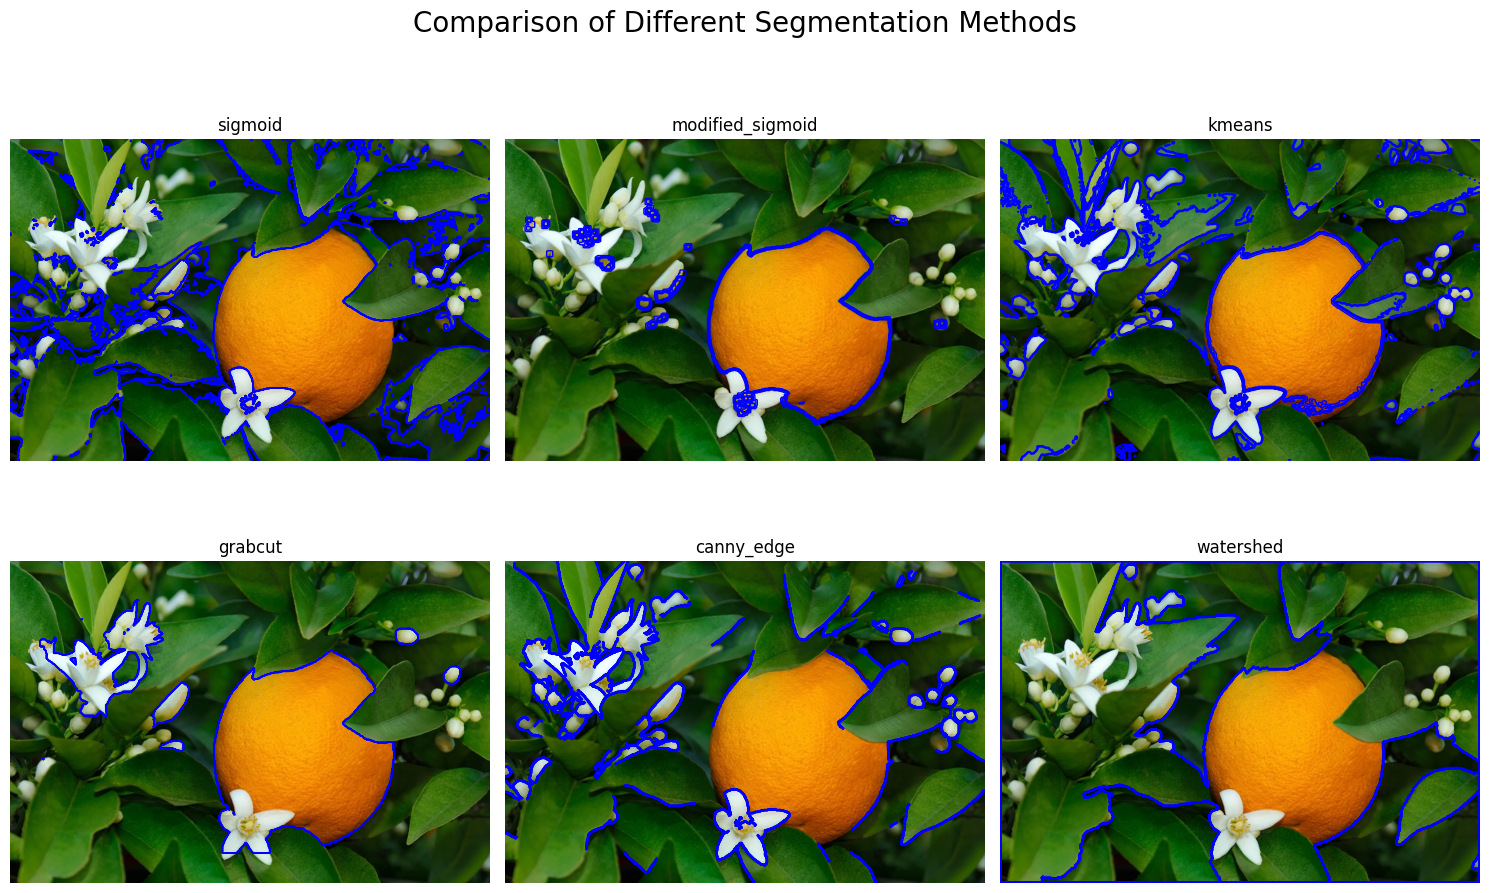

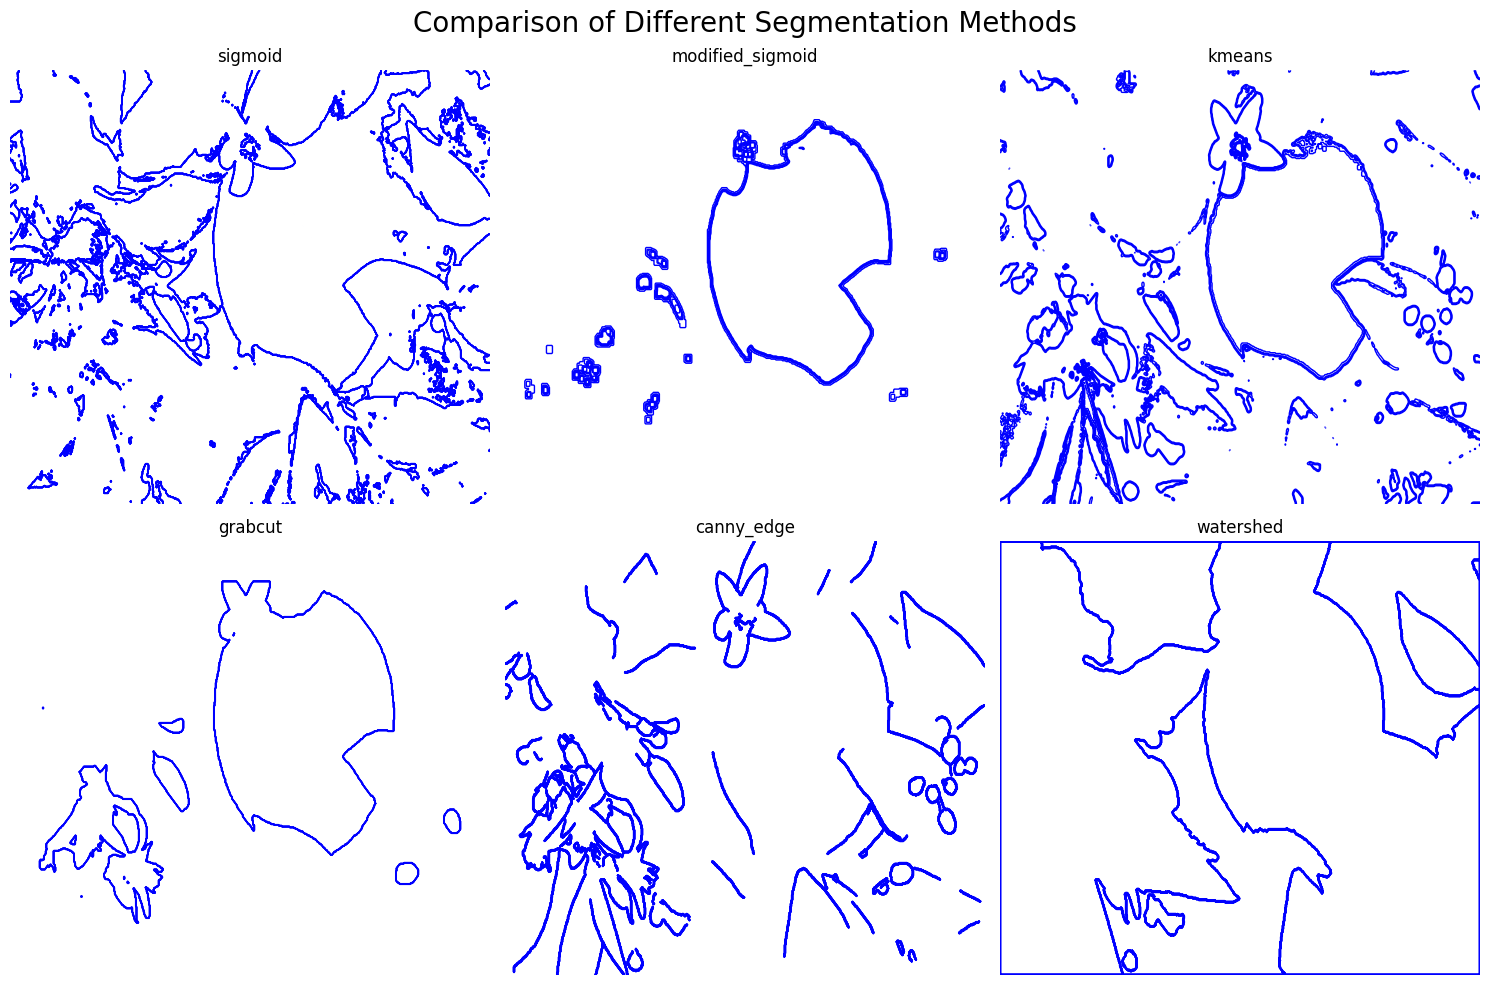

In [57]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import cv2
import torch

# List of all methods you want to apply
methods = ["sigmoid", "modified_sigmoid", "kmeans", "grabcut", "canny_edge","watershed"]

# Dictionary to store results for each method
results = {}

# Loop through all methods
for likelihood_method in methods:
    if likelihood_method == "sigmoid":
        likelihood = img[:,:,0]-img[:,:,1]-img[:,:,2] - 0.5
        likelihood = torch.sigmoid(torch.tensor(1-likelihood).float())
        likelihood = likelihood - torch.min(likelihood)
        likelihood = likelihood / torch.max(likelihood)
        likelihood = (likelihood<0.5).float()

    elif likelihood_method == "modified_sigmoid":
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
        
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        lower_orange = np.array([10, 200, 100])
        upper_orange = np.array([30, 255, 255])
        mask = cv2.inRange(hsv_img, lower_orange, upper_orange)
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)
        likelihood = torch.tensor(mask / 255.0).float()

    elif likelihood_method == "kmeans":
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
        
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        reshaped_img = hsv_img.reshape((-1, 3))
        kmeans = KMeans(n_clusters=3, random_state=0).fit(reshaped_img)
        segmented_img = kmeans.labels_.reshape(img.shape[:2])
        likelihood = torch.tensor(segmented_img / np.max(segmented_img)).float()
        likelihood_np = likelihood.numpy()
        likelihood_np = cv2.GaussianBlur(likelihood_np, (5, 5), 0)
        likelihood = torch.tensor(likelihood_np).float()

    elif likelihood_method == "grabcut":
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        else:
            img = img.astype(np.uint8)
        
        mask = np.zeros(img.shape[:2], np.uint8)
        bgd_model = np.zeros((1, 65), np.float64)
        fgd_model = np.zeros((1, 65), np.float64)
        rect = (50, 50, img.shape[1] - 100, img.shape[0] - 100)
        
        cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
        mask_2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        likelihood = torch.tensor(mask_2).float()

    elif likelihood_method == "canny_edge":
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 100, 200)
        likelihood = torch.tensor(edges / 255.0).float()

    
    elif likelihood_method == "watershed":
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        
        ret, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        
        markers[unknown == 255] = 0
        
        markers = cv2.watershed(img, markers)
        
        mask = np.where(markers == -1, 1, 0).astype('uint8')
        likelihood = torch.tensor(mask).float()

    # Store the result
    results[likelihood_method] = likelihood




# Plot all results in a grid using plot_mask() with lined_contours=True
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparison of Different Segmentation Methods", fontsize=20)

# Plot each segmentation method's result
for i, (method, likelihood) in enumerate(results.items()):
    row, col = divmod(i, 3)
    
    # Show the original image
    axs[row, col].imshow(img)
    # Plot contours on top of the original image
    axs[row, col].contour(likelihood.numpy(), colors='blue', linewidths=1)
    
    # Set title and remove axis labels
    axs[row, col].set_title(method)
    axs[row, col].axis('off')

# Hide the last empty plot if there is one
if len(results) < 6:
    axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Plot all results in a grid using plot_mask() with lined_contours=True
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Comparison of Different Segmentation Methods", fontsize=20)

# Plot each segmentation method's result
for i, (method, likelihood) in enumerate(results.items()):
    row, col = divmod(i, 3)
    
    # Plot contours on top of the original image
    axs[row, col].contour(likelihood.numpy(), colors='blue', linewidths=1)
    
    # Set title and remove axis labels
    axs[row, col].set_title(method)
    axs[row, col].axis('off')

# Hide the last empty plot if there is one
if len(results) < 6:
    axs[1, 2].axis('off')

plt.tight_layout()
plt.show()



likelihood = results["modified_sigmoid"]
# fig = plot_mask(img, likelihood, filled_contours=False, lined_contours=True)
# fig



# Define prior covexity

In [58]:

use_cuda = False
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
height, width = likelihood.shape[-2:]

def get_model_device(model):
    return next(model.parameters()).device

# We need a coordinate grid, which we use to query our implicit representation.
def create_grid(image_shape, device: torch.device):
    ny, nx = image_shape
    x = torch.arange(0, nx, device=device)
    y = torch.arange(0, ny, device=device)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid = torch.stack((xx, yy), dim=0)
    batched_input = grid.unsqueeze(0).float() / torch.tensor([nx, ny], device=device).float().unsqueeze(-1).unsqueeze(-1)
    return batched_input
x = create_grid((height, width), device)

# We define the FG as 0, so we need to invert the mask
unaries = 1 - likelihood.to(device)



seed_all(0)

model = ConvexNextNet(n_hidden_layers=1)
model.to(device)


def plot_loss(loss: torch.Tensor):
    fig, ax = get_mpl_figure(1, 1)
    ax.plot(loss.detach().cpu().numpy())
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training Loss")
    return fig




# Train model with data. 

In [59]:

from awesome.measures.se import SE


def train(
        optimizer: torch.optim.Optimizer, 
        model: ConvexNextNet, 
        unaries: torch.Tensor, 
        num_epochs: int,
        fg_weight: float = 0.66,
        ):
    # Train the model
    loss_full = torch.zeros(num_epochs, dtype=torch.float32)
    model.train()

    criterion = SE(reduction='none')

    batched_input = create_grid(unaries.shape[-2:], unaries.device)
    it = tqdm(range(num_epochs), total=num_epochs, desc=f"Training")
    batched_unaries = unaries.unsqueeze(0).unsqueeze(0)

    background_mask = batched_unaries == 1.
    foreground_mask = ~background_mask

    bg_length = background_mask.sum()
    fg_length = foreground_mask.sum()

    fg_weight = tensorify(fg_weight, device=unaries.device)

    for epoch in it:
        
        out = torch.sigmoid(model(batched_input))
        if torch.isnan(out).any():
            raise ValueError("Output is nan")

        fg_loss = criterion(out[foreground_mask], batched_unaries[foreground_mask])
        bg_loss = criterion(out[background_mask], batched_unaries[background_mask])

        # We are weighting the fg and bg differently to get proper tomato segmentation
        loss = (1 - fg_weight) * (bg_loss.sum() / bg_length) + (fg_weight * (fg_loss.sum() / fg_length))

        loss_full[epoch] = loss.detach().cpu()
            
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # After Each epoch we enforce the convexity of the convex net to ensure the convexity of the model => Weights should be positive
        model.enforce_convexity()

        if (epoch+1) % 50 == 0 or epoch == 0:
            it.set_postfix({'loss': loss.item()})
            
    return model, loss_full





# Inference
With the trained model, infer  and get the segmentation of object.


Training with Adam Optimizer...


Training: 100%|██████████| 200/200 [01:09<00:00,  2.87it/s, loss=0.0582]



Training with AdamW Optimizer...


Training: 100%|██████████| 200/200 [01:06<00:00,  3.00it/s, loss=0.0549]



Training with SGD Optimizer...


Training: 100%|██████████| 200/200 [01:06<00:00,  3.01it/s, loss=0.217]



Training with RMSprop Optimizer...


Training: 100%|██████████| 200/200 [01:06<00:00,  2.99it/s, loss=0.0462]


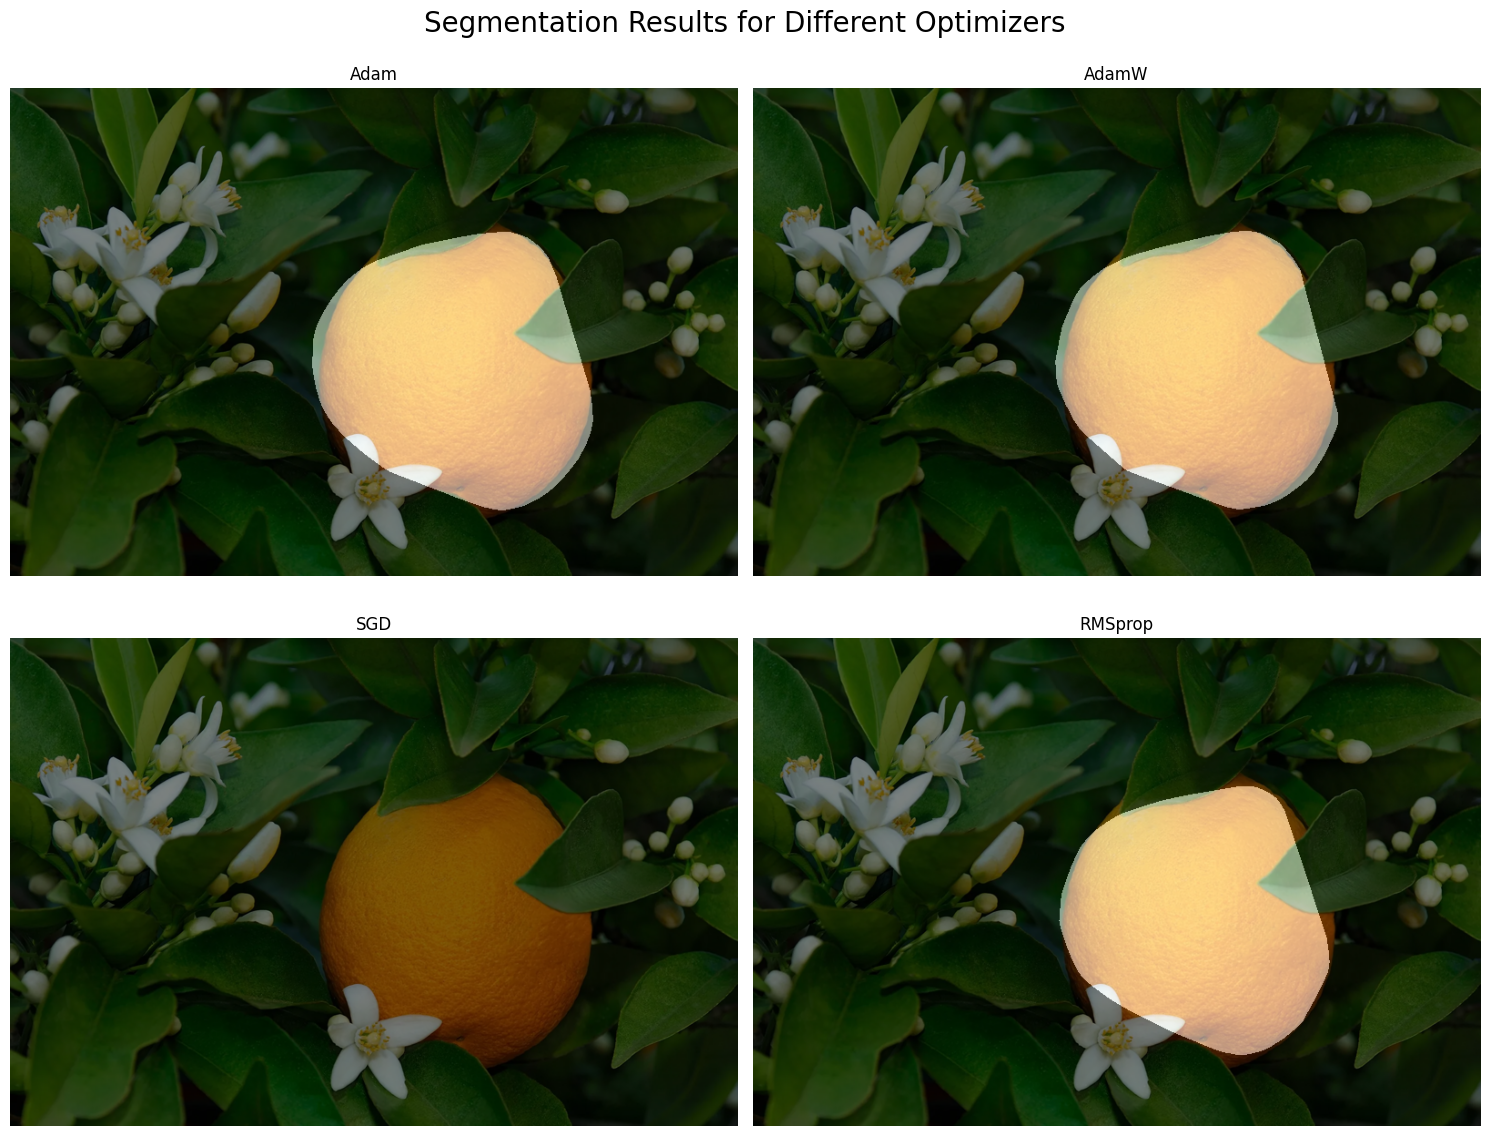

In [60]:
# Using Adamax as optimizer for the flow net was giving us slightly better results than Adam, but feel free to experiment.
from awesome.measures.se import SE
import matplotlib.pyplot as plt

optimizers = {
    "Adam": torch.optim.Adam,
    "AdamW": torch.optim.AdamW,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop,
}


# parameter
lr = 2e-3
momentum=0.9
num_epochs = 200

loss_results = {}

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Segmentation Results for Different Optimizers", fontsize=20)

for idx, (name, optimizer_class) in enumerate(optimizers.items()):
    row, col = divmod(idx, 2)
    
    # Reinitialize the model for each optimizer to ensure fair comparison
    model = ConvexNextNet(n_hidden_layers=1)
    model.to(unaries.device)
    
    # Initialize optimizer
    if name == "SGD":
        optimizer = optimizer_class(model.parameters(), lr, momentum)
    else:
        optimizer = optimizer_class(model.parameters(), lr)
    
    print(f"\nTraining with {name} Optimizer...")
    
    # Train the model
    tm, loss = train(optimizer, model, unaries, num_epochs, fg_weight=0.4)
    loss_results[name] = loss.cpu().numpy()

    # Set model to evaluation mode and generate output
    model.eval()
    with torch.no_grad():
        # Query the model with a grid of coordinates
        in_ = create_grid(unaries.shape[-2:], unaries.device).to(get_model_device(model))
        path_connected_likelihood = model(in_).squeeze().cpu()

    # Generate binary mask from model output
    path_connected_likelihood_mask = torch.sigmoid(path_connected_likelihood) < 0.5

    # Plot the mask for the optimizer
    color = get_named_colors_mapping().get("tab:orange")

    # Plot on subplot
    axs[row, col].imshow(img)
    axs[row, col].imshow(path_connected_likelihood_mask.numpy(), cmap='gray', alpha=0.5)
    axs[row, col].set_title(name)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


# Plot Loss

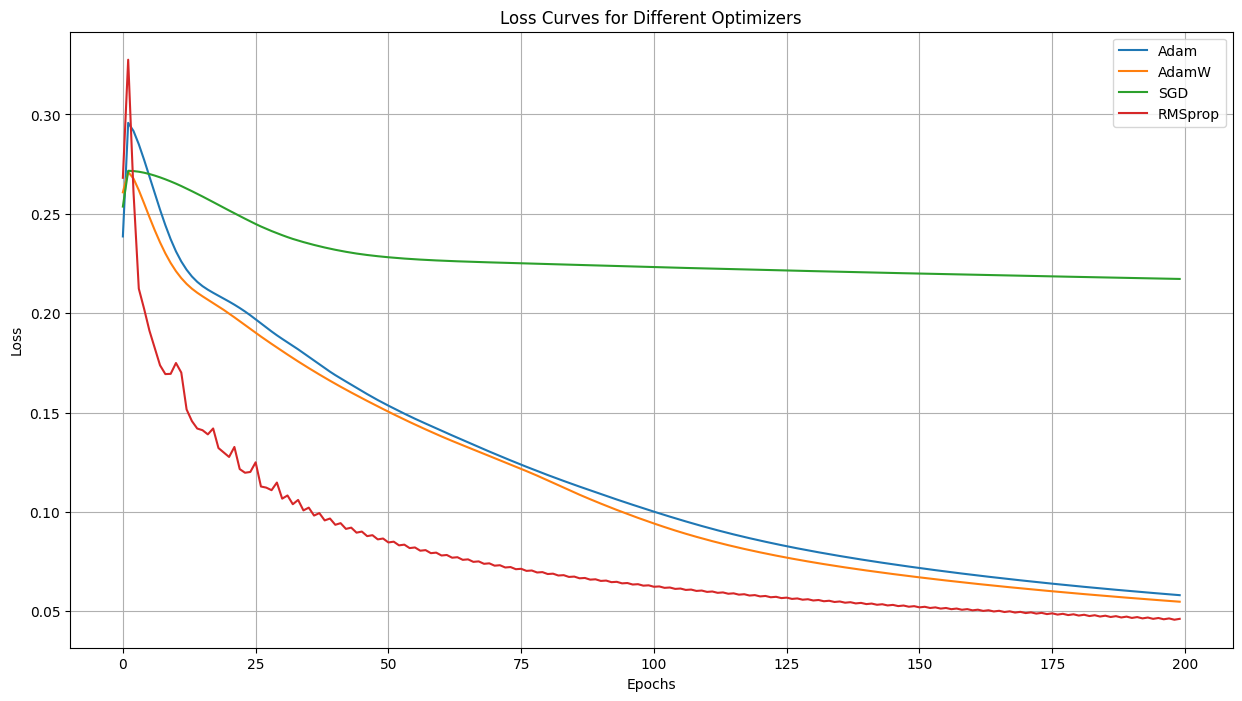

In [61]:
# Plotting loss curves for each optimizer
plt.figure(figsize=(15, 8))
for name, loss in loss_results.items():
    plt.plot(loss, label=name)

plt.title("Loss Curves for Different Optimizers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
